##### $\hspace{15pt}$ **Filename: cycleGAN.ipynb**
##### $\hspace{1.5pt}$ **Date Created: October 3, 2023**
##### **Date Modified: January 4, 2024**
##### $\rule{10.5in}{1pt}$
##### **Load and run a pretrained CycleGAN model. The model was trained on a dataset of horse images and zebra images extracted from the [ImageNet](https://imagenet.stanford.edu) dataset. The model is run on an image that was taken from a [Kaggle dataset](https://www.kaggle.com/datasets/alessiocorrado99/animals10). The content of this notebook is based on the example provided in section 2.2 of the book [Deep Learning with Pytorch](https://www.manning.com/books/deep-learning-with-pytorch). Some changes were made in the presentation of the content as well as in the image that was loaded for demonstration purposes.**
##### $\rule{10.5in}{1pt}$

##### Load modules and packages.

In [1]:
from google.colab import drive
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn

##### Define a ResNet generator.

In [2]:
class ResNetBlock(nn.Module):

    def __init__(self, dim):

        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):

        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size = 3, padding = 0, bias = True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size = 3, padding = 0, bias = True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):

        out = x + self.conv_block(x)

        return out

class ResNetGenerator(nn.Module):

    def __init__(self, input_nc = 3, output_nc = 3, ngf = 64, n_blocks = 9):

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size = 7, padding = 0, bias = True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):

            mult = 2**i
            model += [nn.Conv2d(ngf*mult, ngf*mult*2, kernel_size = 3, stride = 2, padding = 1, bias = True),
                      nn.InstanceNorm2d(ngf*mult*2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf*mult)]

        for i in range(n_downsampling):

            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf*mult, int(ngf*mult/2), kernel_size = 3, stride = 2,
                                         padding = 1, output_padding = 1, bias = True),
                      nn.InstanceNorm2d(int(ngf*mult/2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size = 7, padding = 0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):

        return self.model(input)

##### Create an instance of ResNetGenerator.

In [3]:
resnetG = ResNetGenerator()

##### Mount Google Drive to Colab.

In [4]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##### Load weights to the model.

In [5]:
modelPath = "gdrive/MyDrive/Colab Notebooks/001_cycleGAN/horse2zebra_0.4.0.pth"
modelData = torch.load(modelPath)
resnetG.load_state_dict(modelData)

<All keys matched successfully>

##### Load an image from Google drive.

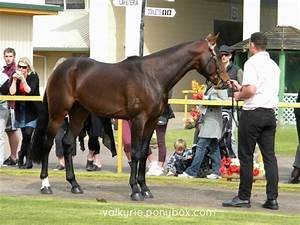

In [6]:
image = Image.open("gdrive/MyDrive/Colab Notebooks/001_cycleGAN/horse.jpg")
image

##### Define a pipeline of preprocessing functions.

In [7]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

##### Apply the preprocessing pipeline to the image.

In [8]:
preprocessedImage = preprocess(image)
unsqueezedImage = torch.unsqueeze(preprocessedImage, 0)

##### Run the pretrained model on the image.

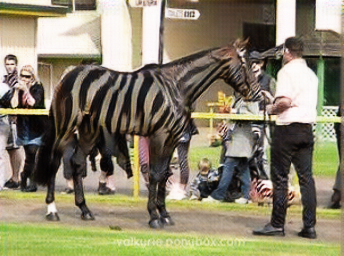

In [9]:
resnetG.eval()
output = resnetG(unsqueezedImage)
squeezedOutput = (output.data.squeeze() + 1.0) / 2.0
outputImage = transforms.ToPILImage()(squeezedOutput)
outputImage